# Using WPS through Jupyter Notebook

## Introduction
The Web Processing Service (WPS) allows you to analyse the data and plot the results for easy understanding. Many different types of analyses are possible. In this demonstration we use the GEOGLAM Fractional Cover Monthly data and calculate the mean value for each time position. The values for three bands (Band 1-3) will be plotted.

In [8]:
##########################################################
# Author: Arapaut V. Sivaprasad.                         #
# Dates: Created: 09/12/2019; Last Modified: 10/2/2020  #
##########################################################

from owslib.wcs import WebCoverageService
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from netCDF4 import Dataset
import warnings
warnings.filterwarnings('ignore')


### Specify the URL of GSKY server and the layer name.

In [9]:
# Specify the GSKY production URL here. The layer is hard coded below.
gsky_url = 'https://gsky.nci.org.au/ows/geoglam'
wcs = WebCoverageService(gsky_url, version='1.0.0')
layer = "modis_fract_cov_monthly"


### Available time positions in the database

In [10]:
# This block of code is for informational purpose only. It lets you see the available time positions.
# To display the available time slices in any range, specify the start and end values as m,n below
time = wcs[layer].timepositions
n_times = len(time)
m = 0
n = n_times

# Unlike in the case of datacube, where a time range can be specified, GSKY requires a specific date.
t = n_times-1

# Uncomment the line below to see all time positions.
#print ("Total of", n_times,'timepositions:\n\n', time[m:n])
print(wcs[layer].timepositions[t])

2020-01-01T00:00:00.000Z


### Construct the bounding box from a polygon
The BBox determines the area on the map to be analysed. The WCS service will return one NetCDF file for each time position. 

You can either give the bounding box values as west,south,east and north coordinates or construct it from a list of coordinates to form a polygon.

The polygon coordinates can be given in any order. To create such a polygon, please refer to the TerriaMap WPS service.

In [11]:
# Type in the polygon coordinates as below. It is NOT necessary to close the polygon, and two points to represent a 
# diagonal will work fine as seen below.

# 5-point closed polygon
polygon = [[141.976, -32.850], [143.689, -33.476], [142.766, -34.713], [141.404, -34.060], [141.976, -32.850]]

# 3-point un-closed polygon
# polygon = [[143.770, -29.414], [145.790, -30.214], [143.418, -30.857]]

# 2-point diagonal
# polygon = [[141.266, -26.583], [144.824, -29.069]]

lon = []
lat = []
lp = len(polygon)
for i in range(lp):
    lon.append((polygon[i][0]))
    lat.append((polygon[i][1]))
lon = sorted(lon)
lat = sorted(lat)
bbox = [str(lon[0]) + ',' + str(lat[lp-1]) + ',' + str(lon[lp-1]) + ',' + str(lat[0])]
bbox

['141.404,-32.85,143.689,-34.713']

### Retrieve the bands and calculate the means

The output from WCS service is converted into a **netCDF4.\_netCDF4.Dataset** in memory. The **Band1, Band2 and Band3** are **numpy.ma.core.MaskedArray** objects. Presumably, it means that the invalid data are already masked. Hence, taking a mean of the array may give the correct result (This must be confirmed!).

By default the entire set of time positions will be used in the analysis. It may take 3-5 minutes to complete depending on the number of time points. You can limit the time points to a specified number from the beginning. It is currently not possible to choose a range, but it can be added if necessary.

In [12]:
# Get the data for each time position
nd = len(wcs[layer].timepositions)

# Specify a number below to limit the time positions processed
# nd = 10

# These arrays keep the raw data as numpy.ma.core.MaskedArray 
orig_Band1 = []
orig_Band2 = []
orig_Band3 = []

# Get the NetCDF files via WCS
for t in range(nd-1):
    output = wcs.getCoverage(identifier=layer, Styles='',
                         time=[wcs[layer].timepositions[t]],
                         bbox=bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)

    # Store the NetCDF as diskless in memory. No writing to the disk even when the file is closed.
    nc = Dataset('dtemp.nc','r',diskless=True,persist=False, memory=output.read())
#     print(nc)
    # Get the band values
    band1 = nc.variables['Band1'][:] 
    band2 = nc.variables['Band2'][:] 
    band3 = nc.variables['Band3'][:] 
    
    # Calculate the mean values
    mean1 = band1.mean() # mean
    orig_Band1.append(mean1)
    mean2 = band2.mean() # mean
    orig_Band2.append(mean2)
    mean3 = band3.mean() # mean
    orig_Band3.append(mean3)
    print(".", end='')
print("")    
print("Mean1: {:0.4f}".format(mean1))
print("Mean2: {:0.4f}".format(mean2))
print("Mean3: {:0.4f}".format(mean3))

....................................................................................................................................................................................................................................
Mean1: 56.7857
Mean2: 7.1630
Mean3: 33.4284


### Plot the values

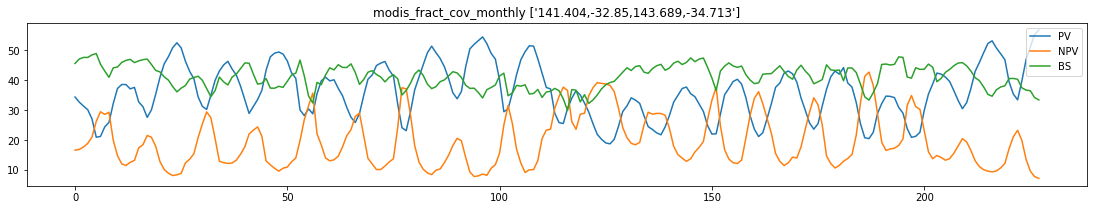

In [13]:
plt.figure(figsize=(19, 3))
Band1 = pd.DataFrame(orig_Band1)
Band2 = pd.DataFrame(orig_Band2)
Band3 = pd.DataFrame(orig_Band3)
ax = plt.subplot(111)
ax.plot(Band1, label='PV')
ax.plot(Band2, label='NPV')
ax.plot(Band3, label='BS')
title = layer + " " + str(bbox)
plt.title(title)
ax.legend()
plt.show()

### Development Notes
(Not to be displayed on the finished page)

- ~~This notebook is a first draft of using the WPS service through Python. It may require further modifications.~~

- The GEOGLAM layer for Monthly Fractional cover is hard coded. It can be changed to any other layer.

- The BBox can be manually entered or constructed from a tile number. It is possible to construct a larger BBox from two tiles, but its code is not implemented here.

- The time range can be specified from 0 to n, but not as a range of n1 to n2. It will require change in code.

- ~~There is some error with the diskless NetCDF. Unlike a \*.nc file it cannot be read into Xarry. This makes it not amenable to processing as in the DEA pages. Hence, instead of converting to xarry, the data from the diskless storage of NetCDF is read directly. It is unclear whether the right data is being read (though almost certainly it is).~~ 

- ~~The invalid data are denoted as '--' in the resulting numpy.ma.core.MaskedArray. I verified that they are omitted when taking the mean values.~~

- ~~The plots are labelled as Band 1,2 and 3. I do not know what they represent (PV, NPV and BS?)~~

- Depending on the BBox there are more than 100 to 300 time points. It takes about 1 sec to process each time point. To speed up we can use parallelisation, but was advised not to use it.

- For the record: The first working version was completed on Mon 9, Dec. Needed to work more with some data issues and plotting options.

## ______End of Notebook_______